# LangGraph 101: Building An Ambient Email Assistant

In this notebook, we're going to build an ambient email assistant from scratch. We will start from a simple router agent and add additional steps into the workflow, showcasing concepts including human-in-the-loop and memory. 

![overview-img](img/overview.png)

For a deeper dive into LangGraph primitives and learning our framework, check out our [LangChain Academy](https://academy.langchain.com/courses/intro-to-langgraph)!

## Pre-work: Setup

To start, let's load our environment variables from our .env file. Make sure all of the keys necessary in .env.example are included!
We use OpenAI in this example, but feel free to swap ChatOpenAI with other model providers that you prefer. 

In [1]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env", override=True)

True

### Setting up LLM

We have added options to use several LLMs below, including OpenAI, AzureOpenAI, and Bedrock. You can run the cell corresponding to your model to set up.

#### OpenAI

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1") # or your model

#### Anthropic 

In [3]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-7-sonnet-20250219") # or your model

#### AWS Bedrock

In [4]:
import os 
from langchain_aws import ChatBedrock

llm = ChatBedrock(model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0") # or your model_id 

#### Azure OpenAI

In [3]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment="gpt-4o",  # or your deployment
    api_version="2025-04-01-preview",  # or your api version
)

### Setting up Short Term Memory

In [4]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

## Part I: Tool-calling React-Agent

Now that we are set up, we are ready to build out our **tool-calling agent**. This is a ReAct-style agent that based on the incoming email, invokes relevant tools to perform the task. 

![agent_workflow_img](img/react_email.png)

### State

How does information flow through the steps?  

State is the first LangGraph concept we'll cover. When defining a Graph, you must pass in a schema for State. The State schema serves as the input schema for all Nodes and Edges in the graph. 

**State can be thought of as the memory of the agent - its a shared data structure that’s passed on between the nodes of your graph and the information that you want to track over time**, representing the current snapshot of your application. 

For our email agent, we'll use LangGraph's pre-built [`MessagesState` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate), which is a just dictionary with a `messages` key that appends messages returned by nodes [as its update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). LangGraph also gives you flexibility to track other information. We'll define a custom `State` object that extends `MessagesState` and adds a `classification_decision` key: 

In [5]:
from langgraph.graph import MessagesState
from typing import Literal

class State(MessagesState):
    # We can add a specific key to our state for the email input
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

### Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are **utilities that can be called by a chat model and can act as extension of the LLM's capabilities**. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description, and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 


In our case, we have defined a number of placeholder tools that have capabilities incl. writing emails, scheduling meeting, checking calendar availabilities, and sending emails. We have also added a Question tool in preparation for our later HITL step, allowing the assistant to ask the user a question.

In [6]:
%cd ..
%load_ext autoreload
%autoreload 2

from datetime import datetime
from pydantic import BaseModel, Field
from langchain_core.tools import tool

from langgraph.types import interrupt, Command
from email_assistant.utils import parse_email, format_for_display, format_email_markdown

# Agent tools 
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
# This is new! 
class Question(BaseModel):
      """Question to ask user."""
      content: str
    
@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool

# All tools available to the agent
tools = [
    write_email, 
    schedule_meeting, 
    check_calendar_availability, 
    Question, 
    Done,
]

tools_by_name = {tool.name: tool for tool in tools}

/Users/qiaocatherine/git/ambient-agent-101


### Nodes

Now that we have a list of tools, we are ready to build nodes that interact with them. 

Nodes are just python (or JS/TS!) functions. Nodes take in your graph's State as input, execute some logic, and return a new State. 

Here, we're just going to set up 2 nodes for our ReAct agent:
1. **LLM Node**: Reasoning node that decides which tool to invoke by calling the LLM. 
2. **Tool Node**: Node that contains all the available tools and executes the function. 

#### Tool Node

LangGraph has a pre-built [ToolNode](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/#toolnode) that you can leverage. You can also build your own tool handler node as below - this is helpful in scenarios when you want to add additional custom logic, such as implementing interrupt before certain tool calls. 

In [7]:
def tool_handler(state: State):
    """Performs the tool call."""

    # List for tool messages
    result = []
    
    # Iterate through tool calls
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = tools_by_name[tool_call["name"]]
        # Run it
        observation = tool.invoke(tool_call["args"])
        # Create a tool message
        result.append({"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]})
    
    # Add it to our messages
    return {"messages": result}

#### LLM Node

Here, we define the LLM decision-making node. This node takes in the current state, calls the LLM, and updates `messages` with the LLM output. 

We [enforce tool use with OpenAI](https://python.langchain.com/docs/how_to/tool_choice/) by setting `tool_choice="required"`.

First, let's import a set of prompt utilities. 

> **Note:** here we change to the parent directory (`%cd ..`) to access our project's module structure, which contains reusable prompts and components. The autoreload extensions ensure any changes to these modules are automatically reflected in the notebook without requiring kernel restarts. This allows us to organize our prompts in a dedicated module rather than defining them inline, making them easier to maintain and reuse across the notebooks! You can see all these files in: `src/email_assistant`


In [9]:
from email_assistant.prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt_hitl_memory, default_triage_instructions, default_background, default_response_preferences, default_cal_preferences
from email_assistant.tools.default.prompt_templates import HITL_MEMORY_TOOLS_PROMPT

# Initialize the LLM, enforcing tool use
llm_with_tools = llm.bind_tools(tools, tool_choice="any")

react_system_prompt = agent_system_prompt_hitl_memory.format(
    tools_prompt=HITL_MEMORY_TOOLS_PROMPT,
    background=default_background,
    response_preferences=default_response_preferences,
    cal_preferences=default_cal_preferences, 
)

print(react_system_prompt)


< Role >
You are a top-notch executive assistant. 
</ Role >

< Tools >
You have access to the following tools to help manage communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings where preferred_day is a datetime object
3. check_calendar_availability(day) - Check available time slots for a given day
4. Question(content) - Ask the user any follow-up questions
5. Done - E-mail has been sent

</ Tools >

< Instructions >
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. IMPORTANT --- always call a tool and call one tool at a time until the task is complete: 
3. If the incoming email asks the user a direct question and you do not have context to answer the question, use the Question tool to ask the user for the answer
4. For responding to the email, draft a response email with the

In [10]:
def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            # Invoke the LLM
            llm_with_tools.invoke(
                # Add the system prompt
                [   
                    {"role": "system", "content": react_system_prompt}
                ]
                # Add the current messages to the prompt
                + state["messages"]
            )
        ]
    }

### Edges

Now, we need to define a control flow that connects between our defined nodes, and that's where the concept of edges come in.

**Edges are connections between nodes. They define the flow of the graph.**
* **Normal edges** are deterministic and always go from one node to its defined target
* **Conditional edges** are used to dynamically route between nodes, implemented as functions that return the next node to visit based upon some logic. 

In this case, we want a **conditional edge** from our LLM node that determines whether to: 
- Invoke tools, or,
- Route to the end if no more tool calls are needed

In [11]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called."""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

### Compile Graph!

Now that we've defined our State and Nodes, let's put assemble the components together and construct our react agent!

In [12]:
from langgraph.graph import StateGraph, START, END
from email_assistant.utils import show_graph

# Build workflow
overall_workflow = StateGraph(State)

# Add nodes
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

# Add edges
overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
overall_workflow.add_edge("tool_handler", "llm_call")

# Compile the agent
agent = overall_workflow.compile()

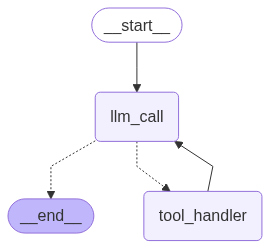

In [13]:
# Show graph 
show_graph(agent)

### Testing

Let's see how it works!

In [14]:
from langchain_core.messages import HumanMessage

email_input = "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"

# Run the agent
response = agent.invoke({"messages": [HumanMessage(content=email_input)]})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi John,
I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?
Specifically, I'm looking at:
- /auth/refresh
- /auth/validate
Thanks!
Alice
================================== Ai Message ==================================
Tool Calls:
  Question (call_q1JPjNk5GqIVbtzE0P2QM8Ln)
 Call ID: call_q1JPjNk5GqIVbtzE0P2QM8Ln
  Args:
    content: Alice has asked if the missing endpoints /auth/refresh and /auth/validate were intentionally excluded from the API documentation or if the documentation needs to be updated. Do you have any information regarding these endpoints that I can share with her?
================================= Tool Message =================================

content='Alice has asked if the missing endpoints /auth/refresh and /auth/validate

### Optional: Using ReAct Agent Pre-Built

LangGraph offers pre-built libraries for common architectures, allowing us to quickly create architectures like ReAct or multi-agent architacture. A full list of pre-built libraries can be found here: https://langchain-ai.github.io/langgraph/prebuilt/#available-libraries 

In the last workflow, we have seen how we can build a ReAct agent from scratch. Now, we will show how we can leverage the LangGraph pre-built libraries to achieve similar results. 

In [35]:
from langgraph.managed.is_last_step import RemainingSteps

class PrebuiltState(MessagesState):
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

    # Using pre-built requires RemainingSteps
    remaining_steps: RemainingSteps 

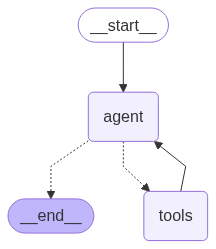

In [36]:
from langgraph.prebuilt import create_react_agent

# Define the agent 
agent_prebuilt = create_react_agent(llm, tools=tools, prompt=react_system_prompt, state_schema=PrebuiltState)

# Visualize the graph
agent_prebuilt

In [17]:
# Run the agent
response = agent_prebuilt.invoke({"messages": [HumanMessage(content=email_input)]})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi John,
I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?
Specifically, I'm looking at:
- /auth/refresh
- /auth/validate
Thanks!
Alice
================================== Ai Message ==================================

[{'text': "I'll help you draft a response to Alice about the API documentation question. Let me prepare an email reply.", 'type': 'text'}, {'id': 'toolu_013KaDcevuM9rLxYv2bzK8cE', 'input': {'to': 'Alice', 'subject': 'RE: API Documentation for Authentication Service', 'content': "Hi Alice,\n\nThank you for bringing this to my attention regarding the missing endpoints in the API documentation for the new authentication service.\n\nI'll investigate whether the omission of the /auth/refresh and /auth/validate endpoints was intention

## Part I.2: Adding Router Logic in Tool-Calling Agent

Now, we have a ReAct-style agent that can respond to incoming emails. However, often times, not all emails are worth responding to. 

Here, we'll add a triage logic with our tool-calling agent to build a [workflow](https://langchain-ai.github.io/langgraph/tutorials/workflows/) for our email assistant, where we will first decide the importance of the email, before triggering the ReAct email agent that we just built. 

![agent_workflow_img](img/email_workflow.png)


#### Router Node

The routing step handles the triage decision, and we define a python function with our triage routing logic.

For this, we use [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) with a Pydantic model. **ChatModels support attaching a structured data schema to adhere response to**. This is useful in scenarios like extracting information or categorizing.   

Pydantic models are particularly useful for defining structured output schemas because it offers type hints and validation. The descriptions in the pydantic model are important because they get passed as part JSON schema to the LLM to inform the output coercion.

In [15]:
class RouterSchema(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

llm_router = llm.with_structured_output(RouterSchema) 

In [17]:
router_system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
)
print(router_system_prompt)



< Role >
Your role is to triage incoming emails based upon instructs and background information below.
</ Role >

< Background >
 
I'm Lance, a software engineer at LangChain.
. 
</ Background >

< Instructions >
Categorize each email into one of three categories:
1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that worth notification but doesn't require a response
3. RESPOND - Emails that need a direct response
Classify the below email into one of these categories.
</ Instructions >

< Rules >

Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updat

In [18]:
print(triage_user_prompt)


Please determine how to handle the below email thread:

From: {author}
To: {to}
Subject: {subject}
{email_thread}


In [60]:
from langgraph.types import Command
def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore."""
    
    author, to, subject, email_thread = parse_email(state["email_input"])

    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Invoke structured LLM to classify Email 
    result = llm_router.invoke(
        [
            {"role": "system", "content": router_system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email: \n\n{format_email_markdown(subject, author, to, email_thread)}",
                }
            ],
            "classification_decision": result.classification,
        }
        
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        goto = END
        update =  {
            "classification_decision": result.classification,
        }
        
    elif result.classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information")
        # For now, we go to END. But we will add to this later!
        goto = END
        update = {
            "classification_decision": result.classification,
        }
        
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

We use [Command](https://langchain-ai.github.io/langgraph/how-tos/command/) objects in LangGraph to both update the state and select the next node to visit. This is a useful alternative to edges.

### Combine workflow 

We can combine the router with our tool-calling ReAct agent from Part 1.1

In [21]:
triage_workflow = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node("response_agent", agent)
    .add_edge(START, "triage_router")
).compile()

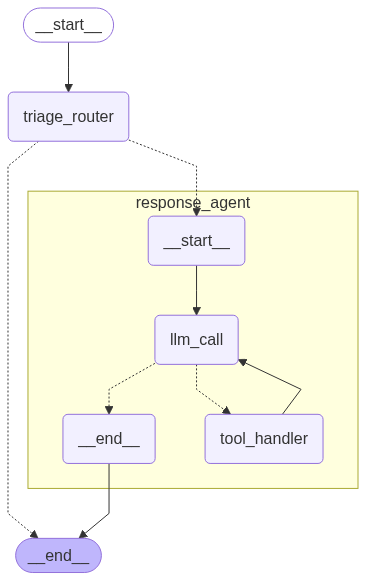

In [22]:
show_graph(triage_workflow, xray=True)

This is a higher-level composition where:
1. First, the triage router analyzes the email
2. If needed, the response agent handles crafting a response
3. The workflow ends when either the triage decides no response is needed or the response agent completes

### Let's test it out!

In [23]:
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

# Run the agent
response = triage_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

🔔 Classification: NOTIFY - This email contains important information


In [24]:
email_input = {
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

# Run the agent
response = triage_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to the email: 



**Subject**: Quick question about API documentation
**From**: Alice Smith <alice.smith@company.com>
**To**: John Doe <john.doe@company.com>

Hi John,
I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?
Specifically, I'm looking at:
- /auth/refresh
- /auth/validate
Thanks!
Alice

---

================================== Ai Message ==================================
Tool Calls:
  Question (call_MqfeKHjuFQazaZpFTZZvfc3a)
 Call ID: call_MqfeKHjuFQazaZpFTZZvfc3a
  Args:
    content: Does Lance have the context to answer Alice's question about the missing API documentation endpoints?
================================= Tool Message =================================

con

## Part II. Human-in-the-loop

We have an email assistant that uses a router to triage emails and then passes the email to the agent for response generation. We've also evaluated it. But do we fully *trust* it to manage our inbox autonomously? For such a sensitive task, human-in-the-loop (HITL) is important! 

In this step, we'll show how to add a human-in-the-loop to our email assistant so that we can review specific tool calls. 

![overview-img](img/overview_hitl.png)


We're going to show how to make the graph *pause* at specific points and await human input.

![overview-img](img/hitl_schematic.png)

Specifically, there are two steps that we want to pause: 
- **triager_interrupt_handler**: Interrupting for "Notify" type emails, allowing user to review
- Adding interrupt to our **tool_handler**, maintaining a list of "HITL tools" that require human approval

### Node 1. Triage Interrupt Handler

If the decision is to `notify` the user, we interrupt the graph! 

![overview-img](img/HITL_flow_triage.png)

For this, we add a new node, `triage_interrupt_handler`, that will: 

1. Show the classification to the user if it is `notify`: We'll pass a `dict` to the interrupt that contains our classification. 
2. Allow the user to respond to the decision: We'll design the code to handle what we will get back from Agent Inbox. 

As you can see [here](https://github.com/langchain-ai/agent-inbox?tab=readme-ov-file#what-do-the-fields-mean), we format our interrupt with specific fields so that it can be viewed in Agent Inbox:

* `action_request`: The action and arguments for the interrupt with `action` (the action name) and `args` (the tool call arguments). This is rendered in the Agent Inbox as the main header for the interrupt event.
* `config`: Configures which interaction types are allowed, and specific UI elements for each. 
* `description`: Should be detailed, and may be markdown. This will be rendered in the Agent Inbox as the description

In [30]:
def triage_interrupt_handler(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step."""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email_markdown}"
                }]

    # Create interrupt that is shown to the user
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True, 
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email_markdown,
    }

    # Agent Inbox responds with a list of dicts with a single key `type` that can be `accept`, `edit`, `ignore`, or `response`.  
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        # Used by the response agent
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # Go to response agent
        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

#### Updating triage logic

Now that we have a new node, `triage_interrupt_handler`, we would want to update our triage routing logic to reflect it.

In this case, if the classification is `notify`, we want to interrupt the graph to allow the user to review the email by routing to `triage_interrupt_handler`.Therefore, updating our `triage_router` logic below. 

In [31]:
def triage_router(state: State) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore."""

    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": router_system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email_markdown}"
                        }],
        }
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        # Next node
        goto = END
        # Update the state
        update = {
            "classification_decision": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 
        # This is new! 
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    return Command(goto=goto, update=update)

In [26]:
def triage_router(state: State) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore."""

    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Format system prompt with background and triage instructions
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    )

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email_markdown}"
                        }],
        }
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        # Next node
        goto = END
        # Update the state
        update = {
            "classification_decision": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 
        # This is new! 
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    return Command(goto=goto, update=update)

In [26]:
def triage_interrupt_handler(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step."""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email_markdown}"
                }]

    # Create interrupt that is shown to the user
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True, 
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email_markdown,
    }

    # Agent Inbox responds with a list of dicts with a single key `type` that can be `accept`, `edit`, `ignore`, or `response`.  
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        # Used by the response agent
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # Go to response agent
        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

### Node 2. Tool Handler with Interrupt

The `tool_handler` with interrupt is the core HITL component of our response agent. This updates our tool node, and its job is to examine the tool calls that the LLM wants to make and determine which ones need human review before execution. Here's how it works:

1. **Tool Selection**: The handler maintains a list of "HITL tools" that require human approval:
   - `write_email`: Since sending emails has significant external impact
   - `schedule_meeting`: Since scheduling meetings affects calendars
   - `Question`: Since asking users questions requires direct interaction

2. **Direct Execution**: Tools not in the HITL list (like `check_calendar_availability`) are executed immediately without interruption. This allows low-risk operations to proceed automatically.

3. **Context Preparation**: For tools requiring review, the handler:
   - Retrieves the original email for context
   - Formats the tool call details for clear display
   - Configures which interaction types are allowed for each tool type

4. **Interrupt Creation**: The handler creates a structured interrupt request with:
   - The action name and arguments
   - Configuration for allowed interaction types
   - A description that includes both the original email and the proposed action

5. **Response Processing**: After the interrupt, the handler processes the human response:
   - **Accept**: Executes the tool with original arguments
   - **Edit**: Updates the tool call with edited arguments and then executes
   - **Ignore**: Cancels the tool execution
   - **Response**: Records feedback without execution

This handler ensures humans have oversight of all significant actions while allowing routine operations to proceed automatically. 

The ability to edit tool arguments (like email content or meeting details) gives users precise control over the assistant's actions.

We can visualize the overall flow: 
![overview-img](img/HITL_flow.png)

In [32]:
def tool_handler(state: State) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Go to the LLM call node next after tool execution 
    goto = "llm_call"

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ["write_email", "schedule_meeting", "Question"]
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute search_memory and other tools without interruption - same logic as before 
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the AI message's tool call with edited content (reference to the message in the state)
            ai_message = state["messages"][-1] # Get the most recent message from the state
            current_id = tool_call["id"] # Store the ID of the tool call being edited
            
            # Create a new list of tool calls by filtering out the one being edited and adding the updated version
            # This avoids modifying the original list directly (immutable approach)
            updated_tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
            ]

            # Create a new copy of the message with updated tool calls rather than modifying the original
            # This ensures state immutability and prevents side effects in other parts of the code
            result.append(ai_message.model_copy(update={"tool_calls": updated_tool_calls}))

            # Update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")
            
        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "Question": 
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Catch all other responses
        else:
            raise ValueError(f"Invalid response: {response}")
            
    # Update the state 
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

### Combine Graph

We can combine the graph together

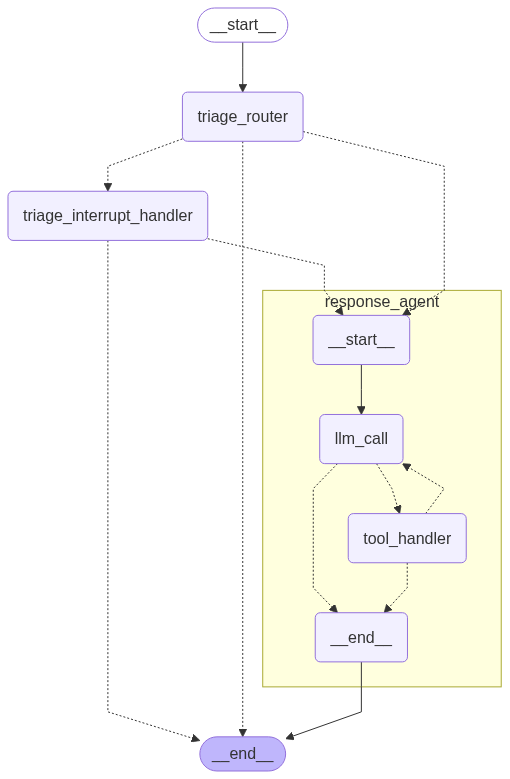

In [33]:
from email_assistant.utils import show_graph
from email_assistant.schemas import StateInput


# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_handler", tool_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
    
)

email_assistant = overall_workflow.compile()
show_graph(email_assistant, xray=True)

### Testing - Let's see this live!

#### Review of HITL Patterns

**Triage Interruption** When an email is classified as "notify", the system interrupts to show the email to the human user
- *User Decision*: User can choose to ignore the notification or provide feedback to respond to the email
- *Flow Control*: If ignored, workflow ends; if user provides feedback, it flows to the Response Agent

**Write Email**: System shows proposed email draft for human review
- *User Decision and Flow Control*: ignore (end workflow), respond with feedback, accept draft as-is, or edit draft

**Schedule Meeting**: System shows proposed meeting details for human review
- *User Decision and Flow Control*: ignore (end workflow), respond with feedback, accept meeting details as-is, or edit details

**Question**: System asks user a question to clarify information
- *User Decision and Flow Control*: ignore (end workflow) or respond with an answer

#### Test 1. Interrupts Allow Us to Review and Accept Tool Calls

In [34]:
import uuid

# Email to respond to
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again. Before the filing deadline, I would highly recommend scheduling a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime soon? Tuesday or Thursday afternoon on May 6, 2025 or May 8, 2025 would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with checkpointer
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until a tool call that we choose to interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies', 'duration_minutes': 45, 'preferred_day': '2025-05-06T00:00:00', 'start_time': 14}}


What happened here? 

We hit the [interrupt](https://langchain-ai.github.io/langgraph/concepts/interrupts/), which paused execution at the tool call. You can see the `action` (tool call name) and `args` (tool call arguments) that we interrupted displayed to the user.

Now, how do we handle the interrupt? This is where the `Command` interface comes in. [The `Command` object has several powerful capabilities](https://langchain-ai.github.io/langgraph/how-tos/command/). We used it to direct the flow of the graph in prior notebooks: 
- `goto`: Specifies which node to route to next
- `update`: Modifies the state before continuing execution

Here, we'll use it to resume the graph from the interrupted state:
- `resume`: Provides the value to return from the interrupt call

We can return whatever value our graph is designed to handle. In our case, the graph is designed to handle a list of dicts with a single key `type` that can be `accept`, `edit`, `ignore`, or `response`. So, we can simply pass `{"type": "accept"}` to the `resume` argument in order to tell the graph that we accept the tool call.

In [35]:
from langgraph.types import Command

print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies', 'duration_minutes': 45, 'preferred_day': '2025-05-06T00:00:00', 'start_time': 14}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': 'Scheduling Call for Tax Planning', 'content': "Hello,\n\nThank you for reaching out regarding tax planning strategies. I've scheduled our call for Tuesday, May 6, 2025, at 2:00 PM, as you suggested, for a duration of 45 minutes.\n\nLooking forward to your suggestions that could save me money.\n\nRegards,\nLance Martin"}}


In [36]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': 'Scheduling Call for Tax Planning', 'content': "Hello,\n\nThank you for reaching out regarding tax planning strategies. I've scheduled our call for Tuesday, May 6, 2025, at 2:00 PM, as you suggested, for a duration of 45 minutes.\n\nLooking forward to your suggestions that could save me money.\n\nRegards,\nLance Martin"}} tool call...


In [37]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again. Before the filing deadline, I would highly recommend scheduling a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime soon? Tuesday or Thursday afternoon on May 6, 2025 or May 8, 2025 would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_YJv1VxMiwnS3jbbuEhrv62ss)
 Call ID: call_YJv1VxMiwnS3jbbuEhrv62ss
  Args:
    day: 2025-05-06
================================= Tool Message =================================

Available times on 2025-05-06: 9:00 AM, 2:00 PM, 4:00 PM
============

#### Test 2. Interrupts Allow Us to Edit Tool Calls

This test demonstrates how human modification works in the HITL flow:
1. We start with the same tax planning email as before
2. The agent proposes a meeting with the same parameters
3. This time, the user EDITS the meeting proposal to change:
   - Duration from 45 to 30 minutes
   - Meeting subject is made more concise
4. The agent adapts to these changes when drafting the email
5. The user further EDITS the email to be shorter and less formal
6. The workflow completes with both modifications incorporated

This scenario showcases one of the most powerful aspects of HITL: 

* Users can make precise modifications to agent actions before they are executed, ensuring the final outcome matches their preferences without having to handle all the details themselves.

In [39]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again. Before the filing deadline, I would highly recommend scheduling a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime soon? Tuesday or Thursday afternoon on May 6, 2025 or May 8, 2025 would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with new thread
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-05-06', 'start_time': 14}}


**Edit the `schedule_meeting` tool call**

When the agent proposes the initial meeting schedule, we now simulate the user making modifications through the edit functionality. This demonstrates how the `edit` response type works:

1. The user receives the same meeting proposal as in the previous test
2. Instead of accepting, they modify the parameters:
   - Reducing duration from 45 to 30 minutes
   - Keeping the same day and time
3. The `edit` response includes the complete set of modified arguments
4. The interrupt handler replaces the original tool arguments with these edited ones
5. The tool is executed with the user's modifications

This shows how edit capability gives users precise control over agent actions while still letting the agent handle the execution details.

In [40]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning Discussion",
    "duration_minutes": 30,  # Changed from 45 to 30
    "preferred_day": "2025-05-06",
    "start_time": 14 
}

for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I have scheduled a call on Tuesday, May 6, 2025 at 2:00 PM for our tax planning discussion. We can extend the meeting if necessary during our call.\n\nLooking forward to our conversation.\n\nBest regards,\nLance Martin'}}


**Edit the `write_email` tool call**

After accepting the modified meeting schedule, the agent drafts an email reflecting the 30-minute duration. Now we demonstrate how editing works with email content:

1. The agent has adapted its email to mention the shorter 30-minute duration
2. We simulate the user wanting an even more significant change to the email:
   - Completely rewriting the content to be shorter and less formal
   - Changing the meeting day mentioned in the email (showing how users can correct agent mistakes)
   - Requesting confirmation rather than stating the meeting as definite
3. The `edit` response contains the complete new email content
4. The tool arguments are updated with this edited content
5. The email is sent with the user's preferred wording

This example shows the power of HITL for complex communication tasks - the agent handles the structure and initial content, while humans can refine tone, style, and substance.

In [41]:
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Hello Project Manager,\n\nThank you for reaching out about tax planning. I believe half an hour would be sufficient for the discussion. I scheduled a 30-minute call on May 6, 2025 at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}

for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_hbo0kMguX4ogVTR5Lrg7qkKJ)
 Call ID: call_hbo0kMguX4ogVTR5Lrg7qkKJ
  Args:
    done: True


Look at the full message history, and see the trace:

https://smith.langchain.com/public/64a4c2c3-0093-463e-b4e7-bbe7060a2beb/r

We can see that user feedback in incorporated into the tool calls.  

#### Test 3. Interrupts Enable New Tools

Now let's try an email that calls the `Question` tool to provide feedback

Finally, we test how feedback works with the `Question` tool:

1. For the brunch invitation email, the agent asks about preferred day and time
2. Instead of ignoring, we provide a substantive response with additional context:
   - Confirming we want to invite the people mentioned
   - Noting we need to check which weekend works best
   - Adding information about needing a reservation
3. The agent uses this information to:
   - Draft a comprehensive email response incorporating all our feedback
   - Notice we didn't provide a specific day/time, so it suggests checking the calendar
   - Include the detail about making a reservation
4. The complete email reflects both the original request and our additional guidance

This demonstrates how question responses can shape the entire workflow:
- Questions let the agent gather missing information
- User responses can include both direct answers and additional context
- The agent integrates all this information into its next actions
- The final outcome reflects the collaborative intelligence of both human and AI

In [42]:
# Respond
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Dinner?",
    "email_thread": "Hey, do you want italian or indian tonight?"}

# Compile the graph
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_6 = uuid.uuid4()
thread_config_6 = {"configurable": {"thread_id": thread_id_6}}

# Run the graph until the first interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'Question', 'args': {'content': 'Do you prefer Italian or Indian food for dinner tonight?'}}


Provide feedback for the `Question` tool call

In [43]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Let's do indian."}]), config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the Question tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'partner@home.com', 'subject': 'RE: Dinner?', 'content': "Hi,\n\nLet's do Indian tonight!\n\nThanks,\nLance"}}


Accept the `write_email` tool call

In [44]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_6):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_cHN1KwmyD61rHHZYXBiPZINX)
 Call ID: call_cHN1KwmyD61rHHZYXBiPZINX
  Args:
    done: True


Look at the full message history, and see the trace:

https://smith.langchain.com/public/3e3df0ea-cb60-4fca-8506-4246809127bd/r

We can see that user feedback in incorporated into the email response.

In [45]:
state = graph.get_state(thread_config_6)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Dinner?
**From**: Partner <partner@home.com>
**To**: Lance Martin <lance@company.com>

Hey, do you want italian or indian tonight?

---

================================== Ai Message ==================================
Tool Calls:
  Question (call_fVwDOJgDoTfREeYOZXjbVRyS)
 Call ID: call_fVwDOJgDoTfREeYOZXjbVRyS
  Args:
    content: Do you prefer Italian or Indian food for dinner tonight?
================================= Tool Message =================================

User answered the question, which can we can use for any follow up actions. Feedback: Let's do indian.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_WmtX3aKasP1QMEYAUhrk0evl)
 Call ID: call_WmtX3aKasP1QMEYAUhrk0evl
  Args:
    to: partner@home.com
    subject: RE: Dinner?
    content: Hi,

Let's do Indian tonight!

Thanks,
Lance
==========

## Part III. Memory

We have an email assistant that uses a router to triage emails and then passes the email to the agent for response generation. We've also evaluated it and added human-in-the-loop (HITL) to review specific tool calls. Now, we add memory, giving our assistant the ability to remember our HITL feedback!

![overview-img](img/overview_memory.png)

### Introduction: Thread-Scoped and Across-Thread Memory

First, it's worth explaining how [memory works in LangGraph](https://langchain-ai.github.io/langgraph/concepts/memory/). LangGraph offers two distinct types of memory that serve complementary purposes:

**Thread-Scoped Memory (Short-term)** operates within the boundaries of a single conversation thread. It's automatically managed as part of the graph's state and persisted through thread-scoped checkpoints. This memory type retains conversation history, uploaded files, retrieved documents, and other artifacts generated during the interaction. Think of it as the working memory that maintains context within one specific conversation, allowing the agent to reference earlier messages or actions without starting from scratch each time.

**Across-Thread Memory (Long-term)** extends beyond individual conversations, creating a persistent knowledge base that spans multiple sessions. This memory is stored as JSON documents in a memory store, organized by namespaces (like folders) and distinct keys (like filenames). Unlike thread-scoped memory, this information persists even after conversations end, enabling the system to recall user preferences, past decisions, and accumulated knowledge. This is what allows an agent to truly learn and adapt over time, rather than treating each interaction as isolated.

![short-vs-long-term-memory](img/short-vs-long.png)

The [Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) is the foundation of this architecture, providing a flexible database where memories can be organized, retrieved, and updated. What makes this approach powerful is that regardless of which memory type you're working with, the same Store interface provides consistent access patterns. This allows your agent's code to remain unchanged whether you're using a simple in-memory implementation during development or a production-grade database in deployment. 

### LangGraph Store

LangGraph offers different [Store implementations](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) depending on your [deployment](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options):

1. **In-Memory (e.g., notebooks)**:
   - Uses `from langgraph.store.memory import InMemoryStore`
   - Purely a Python dictionary in memory with no persistence
   - Data is lost when the process terminates
   - Useful for quick experiments and testing
   - Semantic search can be configured as shown [here](https://langchain-ai.github.io/langgraph/how-tos/memory/semantic-search/)

2. **Local Development with `langgraph dev`**:
   - Similar to InMemoryStore but with pseudo-persistence
   - Data is pickled to the local filesystem between restarts
   - Lightweight and fast, no need for external databases
   - Semantic search can be configured as shown [here](https://langchain-ai.github.io/langgraph/cloud/deployment/semantic_search/)
   - Great for development but not designed for production use

3. **LangGraph Platform or Production Deployments**:
   - Uses PostgreSQL with pgvector for production-grade persistence
   - Fully persistent data storage with reliable backups
   - Scalable for larger datasets
   - Semantic search can be configured as shown [here](https://langchain-ai.github.io/langgraph/cloud/deployment/semantic_search/)
   - Default distance metric is cosine similarity (customizable)

Let's use the `InMemoryStore` here in the notebook! 

In [46]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

Memories are namespaced by a tuple, which in this specific example will be (`<user_id>`, "memories"). The namespace can be any length and represent anything, it does not have to be user specific.

In [47]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

We use the `store.put` method to save memories to our namespace in the store. When we do this, we specify the namespace, as defined above, and a key-value pair for the memory: the key is simply a unique identifier for the memory (memory_id) and the value (a dictionary) is the memory itself.

In [48]:
memory_id = str(uuid.uuid4())
memory = {"food_preference" : "I like pizza"}
in_memory_store.put(namespace_for_memory, memory_id, memory)

We can read out memories in our namespace using the `store.search` method, which will return all memories for a given user as a list. The most recent memory is the last in the list. Each memory type is a Python class (`Item`) with certain attributes. We can access it as a dictionary by converting via `.dict`. The attributes it has are shown below, but the most important one is typically `value`.

In [49]:
memories = in_memory_store.search(namespace_for_memory)
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': '7e42f596-b845-4a3e-ac6c-5ad0f3f4bed9',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-07-10T04:45:21.688342+00:00',
 'updated_at': '2025-07-10T04:45:21.688344+00:00',
 'score': None}

To use this in a graph, all we need to do is compile the graph with the store:

In [50]:
# Compile the graph with the checkpointer and store
# graph = graph.compile(checkpointer=checkpointer, store=in_memory_store)

The store is then accessible in any node of the graph, as we'll see below!

## Adding Memory to our Assistant

Let's take our graph with HITL and add memory to it. This will be very similar to what we had previously. We'll simply update memory in the store when we get feedback from the user.

![overview-img](img/HITL_flow_memory.png)

In [51]:
from email_assistant.prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt_hitl_memory, default_triage_instructions, default_background, default_response_preferences, default_cal_preferences
from email_assistant.tools.default.prompt_templates import HITL_MEMORY_TOOLS_PROMPT

Now, this is the critical part! We currently don't capture any feedback from the user in our graph. 

### Memory Management 

What we *want* to do is fairly straightforward: we want to add the feedback to the memory `Store`. If we compile our graph with the `Store`, we can access it in any node. So that is not a problem! 

To manage memory, we needs to be two considerations:  

1) how do we want the memory to be structured?
2) how do we want to update the memory?

For 1) we'll just store memories as string to keep things simple. In the below function, we'll just fetch memories from the store as string and initialize with default if it doesn't exist.

In [53]:
def get_memory(store, namespace, default_content=None):
    """Get memory from the store or initialize with default if it doesn't exist.
    
    Args:
        store: LangGraph BaseStore instance to search for existing memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        default_content: Default content to use if memory doesn't exist
        
    Returns:
        str: The content of the memory profile, either from existing memory or the default
    """
    # Search for existing memory with namespace and key
    user_preferences = store.get(namespace, "user_preferences")
    
    # If memory exists, return its content (the value)
    if user_preferences:
        return user_preferences.value
    
    # If memory doesn't exist, add it to the store and return the default content
    else:
        # Namespace, key, value
        store.put(namespace, "user_preferences", default_content)
        user_preferences = default_content
    
    # Return the default content
    return user_preferences 

For 2) updating memory, we can use a few tricks from the [GPT-4.1 prompting guide]((https://cookbook.openai.com/examples/gpt4-1_prompting_guide)) to help us update the memory: 

* For optimal performance, repeat the key instructions at the start and end of the prompt
* Create clear, explicit instructions 
* Use XML delimiters for structure
* Provide examples 

In [55]:
MEMORY_UPDATE_INSTRUCTIONS = """
# Role and Objective
You are a memory profile manager for an email assistant agent that selectively updates user preferences based on feedback messages from human-in-the-loop interactions with the email assistant.

# Instructions
- NEVER overwrite the entire memory profile
- ONLY make targeted additions of new information
- ONLY update specific facts that are directly contradicted by feedback messages
- PRESERVE all other existing information in the profile
- Format the profile consistently with the original style
- Generate the profile as a string

# Reasoning Steps
1. Analyze the current memory profile structure and content
2. Review feedback messages from human-in-the-loop interactions
3. Extract relevant user preferences from these feedback messages (such as edits to emails/calendar invites, explicit feedback on assistant performance, user decisions to ignore certain emails)
4. Compare new information against existing profile
5. Identify only specific facts to add or update
6. Preserve all other existing information
7. Output the complete updated profile

# Example
<memory_profile>
RESPOND:
- wife
- specific questions
- system admin notifications
NOTIFY: 
- meeting invites
IGNORE:
- marketing emails
- company-wide announcements
- messages meant for other teams
</memory_profile>

<user_messages>
"The assistant shouldn't have responded to that system admin notification."
</user_messages>

<updated_profile>
RESPOND:
- wife
- specific questions
NOTIFY: 
- meeting invites
- system admin notifications
IGNORE:
- marketing emails
- company-wide announcements
- messages meant for other teams
</updated_profile>

# Process current profile for {namespace}
<memory_profile>
{current_profile}
</memory_profile>

Think step by step about what specific feedback is being provided and what specific information should be added or updated in the profile while preserving everything else."""

MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT = """
Remember:
- NEVER overwrite the entire profile
- ONLY make targeted additions or changes based on explicit feedback
- PRESERVE all existing information not directly contradicted
- Output the complete updated profile as a string
"""

In [85]:
class UserPreferences(BaseModel):
    """User preferences."""
    preferences: str
    justification: str

def update_memory(store, namespace, messages):
    """Update memory profile in the store.
    
    Args:
        store: LangGraph BaseStore instance to update memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        messages: List of messages to update the memory with
    """

    # Get the existing memory
    user_preferences = store.get(namespace, "user_preferences")

    # Update the memory
    user_preference_llm = llm.with_structured_output(UserPreferences)
    result = user_preference_llm.invoke(
        [
            {"role": "system", "content": MEMORY_UPDATE_INSTRUCTIONS.format(current_profile=user_preferences.value, namespace=namespace)},
            {"role": "user", "content": f"Think carefully and update the memory profile based upon these user messages:"}
        ] + messages
    )
    
    # Save the updated memory to the store
    store.put(namespace, "user_preferences", result.preferences)

### Updating Existing Steps with Memory 

Now that we have set up two functions that help us fetch and update memory. We can go and update the logic to store user preferences among our existing nodes. Particularly, there are four steps that need updating:  
1. **triage_router**: Fetches any relevant memory on user routing preferences, when pass to LLM to make triaging decision
2. **triage_interrupt_handler**: Update triage memory when user provides feedback (e.g., respond or ignore).
3. **llm_call**: Add in user preferences for LLM when generating responses 

#### Node 1. `triage_router`
`triage_router` currently categorizes incoming emails into 3 types of categories: respond, ignore, or notify. 
In this step, we will want to fetch relevant memory on triage preferences and pass to the LLM

In [86]:
from langgraph.store.base import BaseStore

def triage_router(state: State, store: BaseStore) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # New step - Search for existing triage_preferences memory
    triage_instructions = get_memory(store, ("email_assistant", "triage_preferences"), default_triage_instructions)

    # Format system prompt with background and triage instructions from memory 
    system_prompt_with_memory = triage_system_prompt.format(
        background=default_background,
        triage_instructions=triage_instructions,
    )

    # Run the router LLM with any preferences from memory
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt_with_memory},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email_markdown}"
                        }],
        }
        
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")

        # Next node
        goto = END
        # Update the state
        update = {
            "classification_decision": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 

        # Next node
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    
    return Command(goto=goto, update=update)


#### Node 2. `triage_interrupt_handler`

`triage_interrupt_handler` currently handles the interrupt for "notify" type emails. 
With memory, we'd want to update triage memory when user provides feedback (e.g., respond or ignore) on "notify" type emails. 

In [87]:
def triage_interrupt_handler(state: State, store: BaseStore) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step"""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email_markdown}"
                }]

    # Create interrupt for Agent Inbox
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True,
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email_markdown,
    }

    # Send to Agent Inbox and wait for response
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # This is new: update triage_preferences with feedback
        update_memory(store, ("email_assistant", "triage_preferences"), [{
            "role": "user",
            "content": f"The user decided to respond to the email, so update the triage preferences to capture this."
        }] + messages)

        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        # Make note of the user's decision to ignore the email
        messages.append({"role": "user",
                        "content": f"The user decided to ignore the email even though it was classified as notify. Update triage preferences to capture this."
                        })
        # This is new: triage_preferences with feedback
        update_memory(store, ("email_assistant", "triage_preferences"), messages)
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

#### Node 3. `llm_call` 

`llm_call` node decides on which tool(s) to invoke or how to respond to an email after tool invocation. 

Now that we have memory managers set up, we can incorporate memory and use the stored preferences when generating responses. 

In [88]:
def llm_call(state: State, store: BaseStore):
    """LLM decides whether to call a tool or not"""

    # Search for existing cal_preferences memory
    cal_preferences = get_memory(store, ("email_assistant", "cal_preferences"), default_cal_preferences)
    
    # Search for existing response_preferences memory
    response_preferences = get_memory(store, ("email_assistant", "response_preferences"), default_response_preferences)

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt_hitl_memory.format(tools_prompt=HITL_MEMORY_TOOLS_PROMPT,
                                                                                         background=default_background,
                                                                                         response_preferences=response_preferences, 
                                                                                         cal_preferences=cal_preferences)}
                ]
                + state["messages"]
            )
        ]
    }

#### Node 4. `tool_handler`

`tool_handler` handles the interrupts and executions of tools. Similarly, we will integrate memory to the node. 

Specifically, if a user: 
- **Edits** or **Responds** to the tool output, then preferences around calendar or responding will be saved 
- **Ignores** the tool response, then triaging preferences are saved 

In [89]:
def tool_handler(state: State, store: BaseStore) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Go to the LLM call node next
    goto = "llm_call"

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ["write_email", "schedule_meeting", "Question"]
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute search_memory and other tools without interruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            initial_tool_call = tool_call["args"]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the AI message's tool call with edited content (reference to the message in the state)
            ai_message = state["messages"][-1] # Get the most recent message from the state
            current_id = tool_call["id"] # Store the ID of the tool call being edited
            
            # Create a new list of tool calls by filtering out the one being edited and adding the updated version
            # This avoids modifying the original list directly (immutable approach)
            updated_tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
            ]

            # Create a new copy of the message with updated tool calls rather than modifying the original
            # This ensures state immutability and prevents side effects in other parts of the code
            result.append(ai_message.model_copy(update={"tool_calls": updated_tool_calls}))

            # Save feedback in memory and update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # This is new: update the memory
                update_memory(store, ("email_assistant", "response_preferences"), [{
                    "role": "user",
                    "content": f"User edited the email response. Here is the initial email generated by the assistant: {initial_tool_call}. Here is the edited email: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Save feedback in memory and update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # This is new: update the memory
                update_memory(store, ("email_assistant", "cal_preferences"), [{
                    "role": "user",
                    "content": f"User edited the calendar invitation. Here is the initial calendar invitation generated by the assistant: {initial_tool_call}. Here is the edited calendar invitation: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":

            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the email draft. That means they did not want to respond to the email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the calendar meeting draft. That means they did not want to schedule a meeting for this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the Question. That means they did not want to answer the question or deal with this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                # This is new: update the memory
                update_memory(store, ("email_assistant", "response_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the response preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                # This is new: update the memory
                update_memory(store, ("email_assistant", "cal_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the calendar preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

    # Update the state 
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

The rest is the same as before!

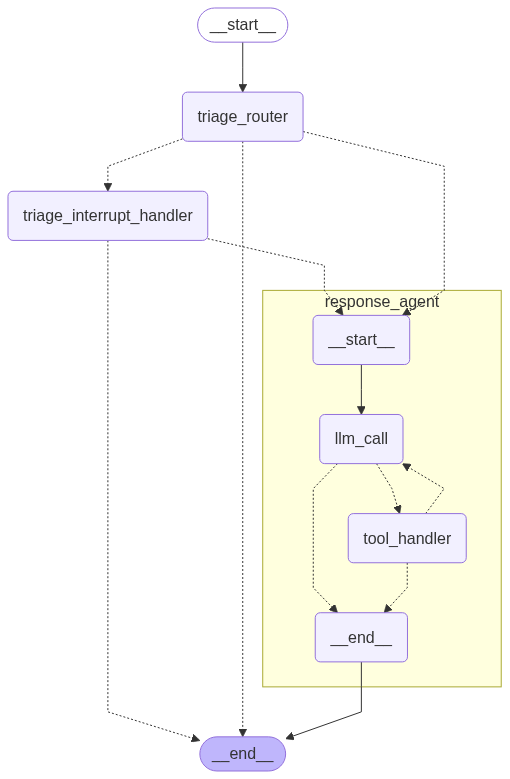

In [90]:
from email_assistant.utils import show_graph

# Conditional edge function
def should_continue(state: State, store: BaseStore) -> Literal["tool_handler", END]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes - with store parameter
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_handler", tool_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow with store and checkpointer
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
)

email_assistant = overall_workflow.compile()
show_graph(email_assistant, xray=True)

### Testing the agent with memory

Now that we've implemented memory into our email assistant, let's test how the system learns from user feedback and adapts over time. This testing section explores how different types of user interactions create distinct memory updates that improve the assistant's future performance.

The key questions we're answering through these tests:
1. How does the system capture and store user preferences?
2. How do these stored preferences affect future decisions?
3. What patterns of interaction lead to which types of memory updates?

First, let's build a helper function to display memory content so we can track how it evolves throughout our tests:

In [91]:
# Helper function to display memory content
def display_memory_content(store, namespace=None):
    # Display current memory content for all namespaces
    print("\n======= CURRENT MEMORY CONTENT =======")
    if namespace:
        memory = store.get(namespace, "user_preferences")
        if memory:
            print(f"\n--- {namespace[1]} ---")
            print({"preferences": memory.value})
        else:
            print(f"\n--- {namespace[1]} ---")
            print("No memory found")
    else:
        for namespace in [
            ("email_assistant", "triage_preferences"),
            ("email_assistant", "response_preferences"),
            ("email_assistant", "cal_preferences"),
        ]:
            memory = store.get(namespace, "user_preferences")
            if memory:
                print(f"\n--- {namespace[1]} ---")
                print({"preferences": memory.value})
            else:
                print(f"\n--- {namespace[1]} ---")
                print("No memory found")
            print("=======================================\n")

#### Test 1. Accept `write_email` and `schedule_meeting`

Our first test examines what happens when a user accepts the agent's actions without modification. This baseline case helps us understand how the system behaves when no feedback is provided:

1. We'll use the same tax planning email from our previous tests
2. The system will classify it as "RESPOND" and propose scheduling a meeting
3. We'll accept the meeting schedule without changes
4. The agent will generate an email confirming the meeting
5. We'll accept the email without changes

This test demonstrates the default behavior of our memory-enabled system. When a user simply accepts proposed actions, we expect minimal or no memory updates since there's no explicit feedback to learn from. However, the system will still leverage existing memory (if any) when generating its responses.

In [92]:
# Respond - Meeting Request Email 
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again. Before the filing deadline, I would highly recommend scheduling a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime soon? Tuesday or Thursday afternoon on May 6, 2025 or May 8, 2025 would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store)

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-05-08', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant inform

**Accept the `schedule_meeting` tool call**

As we examine the initial `schedule_meeting` proposal, note how the system uses existing memory to inform its decisions:

1. The default calendar preferences show a preference for 30-minute meetings, though the email requests 45 minutes
2. The agent still proposes a 45-minute meeting, respecting the sender's specific request
3. We accept this proposal without modification to see if simple acceptance triggers any memory updates

After running this step, we'll check the memory contents to confirm whether acceptance alone leads to memory updates. Simple acceptance represents the baseline user experience - the system works as intended without requiring adjustments.

In [93]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Dear Project Manager,\n\nI hope this message finds you well. Thank you for reaching out regarding tax planning strategies. I have scheduled a call for Thursday afternoon, May 8, 2025, at 2:00 PM for 45 minutes to discuss this further.\n\nPlease let me know if there are any documents or materials you would like me to review before the call.\n\nLooking forward to our discussion.\n\nBest regards,\n\nLance Martin'}}


**Accept the `write_email` tool call**

Now we'll accept the email draft that confirms the meeting scheduling:

1. The email draft is generated with knowledge of our calendar preferences
2. It includes details about the meeting time, duration, and purpose
3. We'll accept it without changes to complete the baseline test case

After accepting, we'll check all memory stores to see if any updates occurred. As expected, simply accepting the agent's proposals doesn't provide strong learning signals - there's no clear feedback about what the user likes or dislikes about the agent's approach.

The trace link shows the complete workflow execution, where we can see that the memory is used in the LLM call for response generation, but no memory updates occur, which is the expected behavior for simple acceptances.

In [94]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting the write_email tool call
display_memory_content(store)


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_7755DsKHyHJFP6WZADKeDOsc)
 Call ID: call_7755DsKHyHJFP6WZADKeDOsc
  Args:
    done: True

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant information for current projects\n- HR Department deadline reminders\n- Subscription status / renewal reminders\

We can look at the full messages, and the trace: 

https://smith.langchain.com/public/fa6ff783-5aa7-4dcc-a115-16fe74505048/r

You'll notice that memory is used in the LLM call to respond. 

But the memory store is *not* updated, because we haven't added any feedback via HITL.

In [79]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again. Before the filing deadline, I would highly recommend scheduling a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime soon? Tuesday or Thursday afternoon on May 6, 2025 or May 8, 2025 would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_naPFWIGZkY8MinjIyaiIs8OV)
 Call ID: call_naPFWIGZkY8MinjIyaiIs8OV
  Args:
    day: 2025-05-06
================================= Tool Message =================================

Available times on 2025-05-06: 9:00 AM, 2:00 PM, 4:00 PM
============

#### Test 2. Edit `write_email` and `schedule_meeting`

This test explores how the system learns from direct edits to its proposed actions. When users modify the agent's suggestions, it creates clear, specific learning signals about their preferences:

1. We'll use the same tax planning email as before
2. When the agent proposes a 45-minute meeting, we'll edit it to:
   - Change the duration to 30 minutes (matching our stored preference)
   - Make the subject line more concise
3. When the agent drafts an email, we'll edit it to be:
   - Shorter and less formal
   - Structured differently

Edits provide the most explicit feedback about user preferences, letting the system learn exactly what changes are desired. We expect to see specific, targeted updates to our memory stores that reflect these edits.

In [99]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again. Before the filing deadline, I would highly recommend scheduling a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime soon? Tuesday or Thursday afternoon on May 6, 2025 or May 8, 2025 would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}
# Compile the graph with new thread
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store,("email_assistant", "cal_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-05-06T14:00:00', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{'preferences': '\n30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n'}


**Edit the `schedule_meeting` tool call**

When we edit the meeting proposal, we're providing direct, explicit feedback about our preferences. This creates a significant learning opportunity for the system:

1. The agent initially proposes a 45-minute meeting (the duration requested in the email)
2. We edit it to 30 minutes and simplify the subject from "Tax Planning Strategies Discussion" to "Tax Planning Discussion"
3. This creates clear, specific feedback about our time preferences and naming conventions

After the edit, we'll check the calendar preferences memory store to see how it's updated. The memory update should capture both:
- Our preference for shorter 30-minute meetings
- Our preference for more concise meeting subjects

The trace reveals the precise memory update logic, showing how the system analyzes the difference between its proposal and our edits to extract meaningful patterns and preferences. We can see the detailed justification for each memory update, ensuring transparency in the learning process.

In [100]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning",
    "duration_minutes": 30, # Changed from 45 to 30
    "preferred_day": "2025-05-06",
    "start_time": 14 
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after editing schedule_meeting
print("\nChecking memory after editing schedule_meeting:")
display_memory_content(store,("email_assistant", "cal_preferences"))


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hi,\n\nThank you for reaching out with the suggestions for tax planning. I've scheduled a call with you to discuss the strategies on Tuesday, May 6, 2025, at 2:00 PM for about 30 minutes.\n\nLooking forward to our meeting.\n\nBest regards,\n\nLance"}}

Checking memory after editing schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{'preferences': '30 minute meetings are preferred, though 15 minute meetings are acceptable.\nWhen scheduling meetings on May 6, include Lance from the company as an attendee and use concise subject lines.\n'}


**An example update:**

```
{'preferences': '\n30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n'}
```

```
{'preferences': "30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n\nUser prefers 30 minute meetings over longer durations such as 45 minutes. When scheduling, default to 30 minutes unless otherwise specified. Subject lines should be concise (e.g., 'Tax Planning Discussion' instead of 'Tax Planning Strategies Discussion')."}
```

Looking at the memory after editing the calendar invitation:

1. The system identifies that we prefer 30-minute meetings over longer durations
2. It's also captured our preference for concise meeting subjects

What's particularly impressive about this memory update is:
- It doesn't just record our specific edit, but generalizes to a broader preference pattern
- It preserves all existing memory content while adding the new information
- It extracts multiple preference signals from a single edit interaction

Now, let's **edit the email draft** to see how the system captures different types of communication preferences:

In [101]:
display_memory_content(store,("email_assistant", "response_preferences"))
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Hello Project Manager,\n\nThank you for reaching out about tax planning. I believe half an hour would be sufficient for us. I scheduled a 30-minute call on May 6, 2025 at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after editing write_email
print("\nChecking memory after editing write_email:")
display_memory_content(store,("email_assistant", "response_preferences"))


======= CURRENT MEMORY CONTENT =======

--- response_preferences ---
{'preferences': "\nUse professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.\n\nWhen responding to technical questions that require investigation:\n- Clearly state whether you will investigate or who you will ask\n- Provide an estimated timeline for when you'll have more information or complete the task\n\nWhen responding to event or conference invitations:\n- Always acknowledge any mentioned deadlines (particularly registration deadlines)\n- If workshops or specific topics are mentioned, ask for more specific details about them\n- If discounts (group or early bird) are mentioned, explicitly request information about them\n- Don't commit \n\nWhen responding to collaboration or project-related requests:\n- Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)\n- Explicitly mention reviewing

Our email edit reveals even more sophisticated learning capabilities:

1. We've shortened and simplified the email content
2. We've added a question asking for confirmation rather than assuming the time works

Looking at the updated memory, we can see that the system has extracted a key insight about our communication style:

```
When scheduling a meeting, ask the recipient to confirm if the proposed time works for them, rather than assuming and stating the meeting is already scheduled.
```

This demonstrates the system's ability to:
- Analyze our edit not just at a superficial level, but to understand intent
- Extract generalizable principles from specific examples
- Preserve all existing guidance while adding new insights
- Maintain the organization and structure of the memory

These targeted, high-quality memory updates will improve all future interactions without requiring repeated corrections.

In [102]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again. Before the filing deadline, I would highly recommend scheduling a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime soon? Tuesday or Thursday afternoon on May 6, 2025 or May 8, 2025 would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_OPOzFFf3XgocvRu8ObzHm1FX)
 Call ID: call_OPOzFFf3XgocvRu8ObzHm1FX
  Args:
    day: 2025-05-06
================================= Tool Message =================================

Available times on 2025-05-06: 9:00 AM, 2:00 PM, 4:00 PM
============

#### Test 3. Respond (with feedback) `write_email`, `schedule_meeting`, and `question`

Our final test set explores the "response" feedback pattern - providing guidance without directly editing or accepting. This conversational feedback mechanism offers a middle ground between acceptance and editing:

1. First, we'll test feedback for meeting scheduling by requesting:
   - Shorter duration (30 minutes instead of 45)
   - Afternoon meeting times (after 2pm)
   
2. Next, we'll test feedback for email drafting by requesting:
   - Shorter, less formal language
   - A specific closing statement about looking forward to the meeting
   
3. Finally, we'll test feedback for questions by providing:
   - A direct answer with additional context
   - Specific preferences (brunch location, time)

This natural language feedback approach lets users guide the assistant without having to do the work themselves. We expect to see detailed memory updates that extract the general principles from our specific feedback.

In [103]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again. Before the filing deadline, I would highly recommend scheduling a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime soon? Tuesday or Thursday afternoon on May 6, 2025 or May 8, 2025 would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}
# Compile the graph
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_5 = uuid.uuid4()
thread_config_5 = {"configurable": {"thread_id": thread_id_5}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt 
display_memory_content(store, ("email_assistant", "cal_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-05-06T14:00:00', 'start_time': 1400}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{'preferences': '\n30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n'}


**Provide feedback for the `schedule_meeting` tool call**

Instead of directly editing the meeting proposal or simply accepting it, we'll provide natural language feedback:

1. We request a 30-minute meeting instead of 45 minutes
2. We express a preference for afternoon meetings after 2pm
3. The system must interpret this feedback and generate a new proposal

This conversational approach is often more natural and efficient than direct editing, especially for mobile users or those who prefer to give high-level direction rather than detailed edits.

After providing feedback, we'll examine the calendar preferences memory to see how this natural language guidance is captured. We expect to see the system extract both the meeting duration and time-of-day preferences as general principles.

In [104]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after providing feedback for schedule_meeting
print("\nChecking memory after providing feedback for schedule_meeting:")
display_memory_content(store, ("email_assistant", "cal_preferences"))


Simulating user providing feedback for the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2025-05-06T14:00:00', 'start_time': 1400}}

Checking memory after providing feedback for schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{'preferences': '<memory_profile>\n\n30 minute meetings are preferred, but 15 minute meetings are also acceptable.\nAfternoon meetings after 2 PM are preferred.\n\n</memory_profile>'}


Our memory check after providing feedback shows an elegantly simple calendar preference update:

```
30 minute meetings are preferred, but 15 minute meetings are also acceptable.
Afternoon meetings after 2pm are preferred.
```

The system has:
1. Captured both aspects of our feedback (duration and time of day)
2. Preserved the existing preference about 15-minute meetings
3. Added our preference for afternoon meetings after 2pm as a new line
4. Kept the format clean and readable

This natural language feedback mechanism creates the same quality of memory updates as direct editing but requires less effort from the user. The system is able to extract structured preferences from unstructured feedback, showing its ability to learn from conversational interactions.

Let's accept this revised meeting proposal and move to the email draft:

In [105]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting schedule_meeting after feedback
print("\nChecking memory after accepting schedule_meeting after feedback:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hello,\n\nThank you for reaching out. I've scheduled a call to discuss tax planning strategies on Tuesday, May 6, 2025 at 2:00 PM for 30 minutes.\n\nWe look forward to exploring your suggestions and optimizing our approach before the filing deadline.\n\nBest regards,\n\nLance Martin"}}

Checking memory after accepting schedule_meeting after feedback:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---
{'preferences': "\nUse professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.\n\nWhen responding to technical questions that require investigation:\n- Clearly state whether you will investigate or who you will ask\n- Provide an estimated timeline for when you'll hav

**Now provide feedback for the `write_email` tool call**

Similar to our meeting feedback, we'll now provide natural language guidance for the email draft:

1. We request "shorter and less formal" language - a style preference
2. We ask for a specific closing statement about looking forward to the meeting
3. The system must interpret this guidance and rewrite the email accordingly

After providing this feedback, we'll check the response preferences memory to see how these style and structure preferences are captured. We expect to see generalizable guidelines about email brevity, formality, and closing statements added to our preference profile.

In [106]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]), config=thread_config_5):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after providing feedback for write_email
print("\nChecking memory after providing feedback for write_email:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hello,\n\nI've scheduled our call to discuss tax planning strategies for Tuesday, May 6, 2025, at 2:00 PM.\n\nLooking forward to your suggestions!\n\nBest,\nLance"}}

Checking memory after providing feedback for write_email:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---
{'preferences': "<memory_profile>\n\nUse professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.\n\nWhen responding to technical questions that require investigation:\n- Clearly state whether you will investigate or who you will ask\n- Provide an estimated timeline for when you'll have more information or complete the task\n\nWhen responding to event or conference invitations:\n- Alwa

The memory update after our email feedback shows sophisticated learning about both meeting scheduling and email writing preferences:

1. The system has added a complete new section to the response preferences entitled "When writing email responses" with two key preferences:
   - "Favor shorter and less formal language when possible, unless the context requires formality"
   - "Include a closing statement expressing that you look forward to the meeting or conversation when confirming appointments"

2. It has also added a new bullet point to the "When responding to meeting scheduling requests" section:
   - "When scheduling meetings, prefer afternoon times after 2pm when possible, and default to 30-minute durations unless otherwise specified"

This demonstrates the system's ability to:
- Organize learned preferences into appropriate categories
- Extract multiple insights from a single feedback instance
- Apply meeting preferences to both calendar and email contexts
- Capture nuance with appropriate qualifiers ("when possible," "unless otherwise specified")
- Maintain the hierarchical structure of the memory

The resulting email shows all these preferences applied: it's shorter, less formal, includes a closing statement about looking forward to the chat, and correctly references the 30-minute meeting time.

In [107]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting write_email after feedback
print("\nChecking memory after accepting write_email after feedback:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user accepting the write_email tool call...

Checking memory after accepting write_email after feedback:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---
{'preferences': "<memory_profile>\n\nUse professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.\n\nWhen responding to technical questions that require investigation:\n- Clearly state whether you will investigate or who you will ask\n- Provide an estimated timeline for when you'll have more information or complete the task\n\nWhen responding to event or conference invitations:\n- Always acknowledge any mentioned deadlines (particularly registration deadlines)\n- If workshops or specific topics are mentioned, ask for more specific details about them\n- If discounts (group or early bird) are mentioned, explicitly request information about them\n- Don't commit\n\nWhen responding to collaboration or project-relat

Look at the full message history.

In [70]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again. Before the filing deadline, I would highly recommend scheduling a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime soon? Tuesday or Thursday afternoon on May 6, 2025 or May 8, 2025 would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (toolu_bdrk_01Nct7omsNgDdC7D6AaG4mSH)
 Call ID: toolu_bdrk_01Nct7omsNgDdC7D6AaG4mSH
  Args:
    day: 2025-05-06
================================= Tool Message =================================

Available times on 2025-05-06: 9:00 AM, 2:00 PM, 4:00 PM


## Part IV. Deployment

You can find this graph with memory integration in the `src/email_assistant` directory:

* `src/email_assistant/email_assistant_hitl_memory.py`

Email to test: 
```
{
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}
```

Testing and Deploying with LangGraph Platform gives you the full experience of a memory-enabled HITL system:

1. **Deploy with LangGraph Platform**: Create a deployment on LangGraph Platform 
2. **Connect Agent Inbox**: Use the graph URL from the deployment to view in [Agent Inbox](https://github.com/langchain-ai/agent-inbox), our UI for human-in-the-loop LangGraph agents. You can follow the instructions to spin up a local version, or simply use the hosted version at [dev.agentinbox.ai](dev.agentinbox.ai)
3. **Submit test emails**: Try different email types to see classification in action
4. **Provide various feedback types**: Try accepting, editing, ignoring, and responding
5. **Observe memory evolution**: Check the Memory tab in LangGraph Studio to see changes






![inbox](img/agent-inbox-edit.png)